# Background
In this example we go over technical details of creating custom `sklearn` transfomer and using it together with `Pipeline` to to tune transformer parameters.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import (
    TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, train_test_split)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# 1. Import data

In [2]:
FILE_PATH = '../yandex_praktikum/course_12/data/taxi.csv'

In [3]:
orders = pd.read_csv(FILE_PATH, index_col='datetime', parse_dates=['datetime'])
orders.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
orders_hourly = orders.resample('1h').sum()
orders_hourly.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Create custom transformer
We'll use the transformer with `GridSearchCV` to tune lag/rolling window size parameters.

In [5]:
class TimeseriesFeatureMaker(BaseEstimator, TransformerMixin):
    """Create timeseries features based on DatetimeIndex and target variable

    Parameters
    ----------
    rolling_mean_size (int): Rolling window size for target variable.
    n_lags (int): Max numer of lagged measures from target.
    target (str, default 'num_orders'): Target variable name in dataset
    datetime_features (bool, default True)
    """
 
    def __init__(self,
                 rolling_mean_size,
                 n_lags,
                 target='num_orders',
                 datetime_features=True):
        
        self.target = target
        self.rolling_mean_size = rolling_mean_size
        self.n_lags = n_lags
        self.datetime_features = datetime_features
            
    
    def fit(self, X, y=None):
        """Set X and y to be used for later transformation"""

        self.X = X.drop(columns=[self.target])
        self.y = X[self.target]
        
        return self
    
    
    def transform(self, X):
        """Create features
        
        Missing lagged and rolling mean values are filled from fitted
        target values. E.g. first row of a transformed dataset will have
        lag_1 value filled from last target value in a fitted set.
        """
        
        temp_df = X.copy()
        
        # add lags
        for lag in range(1, self.n_lags + 1):
            temp_df[f'lag_{lag}'] = temp_df[self.target].shift(lag)
        
        temp_df['rolling_mean'] = temp_df[self.target].rolling(
            f'{int(self.rolling_mean_size)}h', closed='left').mean()
        
        # fill nulls from fitted set values
        for lag in range(1, self.n_lags + 1):            
            temp_df.iloc[:lag, lag] = self.y[-lag:].values
            
        temp_df.loc[:self.rolling_mean_size, 'rolling_mean'] = \
        self.y[-self.rolling_mean_size:].values
            
        # add DatetimeIndex-based features
        if self.datetime_features:
            temp_df['dow'] = temp_df.index.dayofweek
            temp_df['hour'] = temp_df.index.hour
            temp_df['week'] = temp_df.index.week
            temp_df['dom'] = temp_df.index.day
       
        return temp_df.drop(columns=['num_orders'])

Instantiate a transfomer.

In [6]:
fm = TimeseriesFeatureMaker(target='num_orders', rolling_mean_size=6, n_lags=6)
fm

TimeseriesFeatureMaker(datetime_features=True, n_lags=6, rolling_mean_size=6,
                       target='num_orders')

Check transformed data.

In [7]:
fm.fit_transform(orders_hourly).head(10)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean,dow,hour,week,dom
datetime,,,,,,,,,,,
2018-03-01 00:00:00,205.0,223.0,159.0,154.0,136.0,207.0,207.000000,3,0,9,1
2018-03-01 01:00:00,124.0,205.0,223.0,159.0,154.0,136.0,136.000000,3,1,9,1
2018-03-01 02:00:00,85.0,124.0,205.0,223.0,159.0,154.0,154.000000,3,2,9,1
2018-03-01 03:00:00,71.0,85.0,124.0,205.0,223.0,159.0,159.000000,3,3,9,1
2018-03-01 04:00:00,66.0,71.0,85.0,124.0,205.0,223.0,223.000000,3,4,9,1
2018-03-01 05:00:00,43.0,66.0,71.0,85.0,124.0,205.0,205.000000,3,5,9,1
2018-03-01 06:00:00,6.0,43.0,66.0,71.0,85.0,124.0,65.833333,3,6,9,1
2018-03-01 07:00:00,12.0,6.0,43.0,66.0,71.0,85.0,47.166667,3,7,9,1
2018-03-01 08:00:00,15.0,12.0,6.0,43.0,66.0,71.0,35.500000,3,8,9,1


# 3. Create Pipeline and tune parameters
Prepare training and test sets.

In [8]:
features_train, features_test, target_train, target_test = train_test_split(
    orders_hourly, orders_hourly['num_orders'], test_size=.1, shuffle=False
)

print(f'Train lenght: {len(target_train)}')
print(f'Test lenght: {len(target_test)}')

Train lenght: 3974
Test lenght: 442


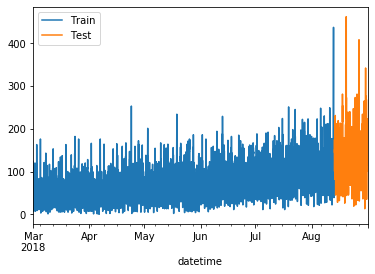

In [9]:
target_train.plot(label='Train')
target_test.plot(label='Test')
plt.legend()

We can observer an increasing trend towards the end of dataset – this can affect prediction quality. Also few outliers are present. We won't address this issue as part of this exercise.

Create a Pipeline with `TimeseriesFeatureMaker` transformer and estimator.

In [10]:
pipe = Pipeline([
    ('transformer', TimeseriesFeatureMaker(n_lags=5, rolling_mean_size=3)),
    ('estimator', LinearRegression())
])

Define parameter grid for grid search.

In [11]:
RND_STATE = 42

params_grid = [
#     {
#         'estimator': [LinearRegression()],
#         'transformer__n_lags': range(12, 125, 12),
#         'transformer__rolling_mean_size': range(12, 73, 12)
#     },

    {
        'estimator': [Lasso(random_state=RND_STATE)],
        'estimator__alpha': np.logspace(-3, 1, 5),
        'transformer__n_lags': range(12, 125, 12),
        'transformer__rolling_mean_size': range(12, 49, 12)
    },
#     {
#         'estimator': [lgb.LGBMRegressor(random_state=RND_STATE)],
#         'estimator__num_leaves': [100, 200],
#         'estimator__min_data_in_leaf': [5, 10, 15, 20],
#         'estimator__max_depth': range(2, 6, 1),
#         'transformer__n_lags': range(12, 125, 12),
#         'transformer__rolling_mean_size': range(12, 73, 12)
#     }
]

Tune parameters.

In [12]:
# timeseries CV with 3 splits
cv = TimeSeriesSplit(3)

grid = GridSearchCV(pipe, params_grid, scoring='neg_mean_squared_error',
                    verbose=1, cv=cv, n_jobs=-1)

grid.fit(features_train, target_train)

print(f'Best cross-validation RMSE: {np.abs(grid.best_score_) ** .5}\n')

best_model = grid.best_estimator_
print('Best model:\n', best_model)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.7s


Best cross-validation RMSE: 24.228024665277594

Best model:
 Pipeline(memory=None,
         steps=[('transformer',
                 TimeseriesFeatureMaker(datetime_features=True, n_lags=120,
                                        rolling_mean_size=36,
                                        target='num_orders')),
                ('estimator',
                 Lasso(alpha=10.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=42, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.6s finished


# 4. Test the model

In [13]:
predictions = best_model.predict(features_test)

Test set RMSE: 39.908305133721086


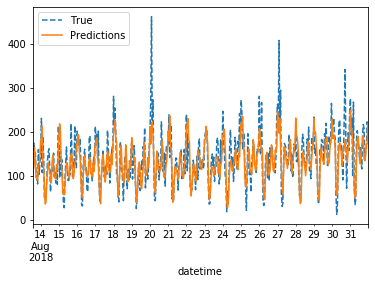

In [14]:
print(f'Test set RMSE: {mean_squared_error(target_test, predictions) ** .5}')
target_test.plot(label='True', linestyle='--')
pd.Series(predictions, index=target_test.index).plot(label='Predictions')
plt.legend()
plt.show()

# 5. Explore CV results.
`GridSearchCV` has a useful `cv_results_` attribute containing data such as fit and score times, scores and parameters used for training.

In [15]:
pd.options.display.float_format = '{:.4f}'.format

cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__alpha,param_transformer__n_lags,param_transformer__rolling_mean_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0623,0.0116,0.0391,0.0014,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",0.0010,12,12,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-861.3072,-930.5420,-1381.5721,-1057.8071,230.6747,185
1,0.0564,0.0049,0.0388,0.0035,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",0.0010,12,24,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-853.4985,-926.7702,-1369.1226,-1049.7971,227.7700,181
2,0.0509,0.0094,0.0413,0.0043,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",0.0010,12,36,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-860.1403,-934.0218,-1383.2868,-1059.1496,231.1757,188
3,0.0450,0.0029,0.0367,0.0021,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",0.0010,12,48,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-869.7742,-932.5452,-1375.7375,-1059.3523,225.1810,190
4,0.0949,0.0153,0.0751,0.0046,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",0.0010,24,12,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-617.8937,-665.8265,-1020.4261,-768.0488,179.5274,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.2892,0.0106,0.2704,0.0102,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",10.0000,108,48,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-503.1411,-529.6114,-801.3875,-611.3800,134.7895,11
196,0.3126,0.0103,0.3102,0.0350,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",10.0000,120,12,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-477.8637,-506.0992,-779.9254,-587.9628,136.2267,2
197,0.3155,0.0158,0.2930,0.0031,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",10.0000,120,24,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-477.8644,-506.0993,-779.9255,-587.9631,136.2265,3
198,0.3175,0.0150,0.2544,0.0418,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",10.0000,120,36,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-474.9667,-506.0993,-779.9256,-586.9972,137.0117,1


For example, one can pick best model/parameter combination (based on `mean_test_score`) from `cv_results`.

In [16]:
# convert MSE to RMSE
cv_results['mean_test_score'] = cv_results['mean_test_score'].abs() ** .5

# best model per model type
best_idx = cv_results.groupby(cv_results['param_estimator'].astype('str').str.split(
    pat='(').str[0])['mean_test_score'].idxmin()

cv_results.loc[best_idx, :].sort_values('mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__alpha,param_transformer__n_lags,param_transformer__rolling_mean_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
198,0.3175,0.0150,0.2544,0.0418,"Lasso(alpha=10.0, copy_X=True, fit_intercept=T...",10.0000,120,36,"{'estimator': Lasso(alpha=10.0, copy_X=True, f...",-474.9667,-506.0993,-779.9256,24.2280,137.0117,1


We've only used Lasso regression in this example, so one row is displayed.